In [2]:
train_x_list = "/kaggle/input/wisdm-data-set/wisdm/x_train.npy"
train_y_list = "/kaggle/input/wisdm-data-set/wisdm/y_train.npy"
test_x_list = "/kaggle/input/wisdm-data-set/wisdm/x_test.npy"
test_y_list = "/kaggle/input/wisdm-data-set/wisdm/y_test.npy"
import datetime
import os
import csv
import numpy as np
import random
import shutil
import torch
import argparse
from torch.cuda.amp import autocast as autocast
from torch.cuda.amp import GradScaler
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import torch.utils.data as Data
from collections import Counter
from imblearn.over_sampling import BorderlineSMOTE

from sklearn.model_selection import train_test_split

import argparse

parser = argparse.ArgumentParser()

import torch

parser = argparse.ArgumentParser(description="Experiment Info and Setings, Model Hyperparameters")
parser.add_argument("--lambda_cls", type=float, default=1)
parser.add_argument("--lambda_sc", type=float, default=2)
parser.add_argument("--lambda_st", type=float, default=0.2)
parser.add_argument("--lambda_cos_loss", type=float, default=2)
# Experiment Info
parser.add_argument("--experiment_date", type=str, default=f"{datetime.datetime.now().strftime('%Y%m%d')}")
parser.add_argument("--experiment_time", type=str, default=f"{datetime.datetime.now().strftime('%H:%M:%S')}")
parser.add_argument("--characteristic", '-c', type=str, default="")
parser.add_argument("--data", type=str, default='Sleep-edf')
parser.add_argument("--data_type", type=str, default='epoch')
parser.add_argument("--scheme", type=str, default='M_M')
parser.add_argument("--loss_weight", type=int, default=1)
parser.add_argument("--lstm_layers", type=int, default=1)
parser.add_argument("--cos_loss", type=int, default=1)
parser.add_argument("--mha", type=int, default=1)
parser.add_argument("--mha_length", type=int, default=8)
parser.add_argument("--mha_head", type=int, default=2)
parser.add_argument("--mass_ch", type=str, default='eeg_f4-ler')
parser.add_argument("--downsample", type=int, default=100)
# Experiment Hyperparameters
parser.add_argument("--epoch", type=int, default=150)
parser.add_argument("--lr", type=float, default=1e-3)
parser.add_argument("--wd", type=float, default=1e-3)
parser.add_argument("--batch", type=int, default=64)
parser.add_argument("--early_stop", type=int, default=50)
parser.add_argument("--dropout", type=int, default=0.5)
parser.add_argument("--scheduler", type=int, default=0)
parser.add_argument("--stride", type=str, default=2)
parser.add_argument("--preprocess", type=str, default='robustscale')
# Model Hyperparameters
parser.add_argument("--seq_length", type=int, default=8)
# GPU
parser.add_argument("--GPU", type=bool, default=True)
parser.add_argument("--gpu_idx", type=int, default=-1)
# Experiment Sbj
parser.add_argument("--range_start", type=int, default=0)
parser.add_argument("--range_end", type=int, default=31)
args = parser.parse_args(args=[])
#args = parser.parse_known_args()[0]

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, lr_scheduler
from torch import default_generator  # type: ignore
from typing import Tuple
from torch import Tensor, Generator
import mne
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, Dataset
from numpy.random import shuffle



/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
def record_name(cv_i):
    # return args.characteristic + '_Finetuning_Model_' + args.finetuning_model_name + str(args.lr_finetune_network)
    return args.characteristic + '_CV_' + str(cv_i)


def writelog(file, line):
    with open(file, 'a', encoding='utf-8') as f:
        f.write(line + '\n')
    print(line + '\n')

def label_stage_transition(label_list):
    for l in range(len(label_list)):
        label_shape = label_list[l].shape
        label = label_list[l].flatten()
        lbl = np.zeros_like(label)
        for i in range(1, len(label)):
            if i != len(label) - 1:
                if label[i] == label[i - 1] and label[i] == label[i + 1]:
                    lbl[i] = 0
                else:
                    lbl[i] = 1
            else:
                if label[i] == label[i - 1]:
                    lbl[i] = 0
                else:
                    lbl[i] = 1
        #cls, count = np.unique(lbl, return_counts=True)
        #writelog(log_file, f'Lable Count: {dict(zip(cls, count))}')
        lbl = lbl.reshape(label_shape)
        label_list[l] = lbl
    return label_list

def float_tensor(x):
    return torch.FloatTensor(x)

def long_tensor(x):
    return torch.LongTensor(x)

def dcn(x):  # detach, cpu, numpy
    if type(x) == np.ndarray:
        return x
    else:
        return x.detach().cpu().numpy()

def pb_argmax(x):
    if len(x.shape) == 1:
        return (x)
    else:
        return np.argmax(x, axis=-1)

def flatten_1dim(x):
    if len(x.shape) == 1:
        return (x)
    else:
        return x.flatten()

def flatten_logit_list(l):
    for i in range(len(l)):
        l[i] = l[i].flatten(end_dim=1)
    return l

def standardize(x):
    return (x - x.mean(axis=1)[:, None]) / x.std(axis=1)[:, None]

def downsample_to_100(x):
    x = mne.filter.resample(x, down=2.56, axis=-1)
    return x

def tr_val_split(idx_tr, idx_val, X_tr_val, Y_tr_val):
    return X_tr_val[idx_tr], Y_tr_val[idx_tr], X_tr_val[idx_val], Y_tr_val[idx_val]

def pytorch_sliding_window(x, window_size, step_size=1):
    # Unfold Dimension to Make Slding Window
    return x.unfold(0, window_size, step_size)

''' Count Parameters '''


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

''' Loss '''

def loss_cross_entropy(weight=None, reduction='mean'):  # Take Logit as an Input
    return nn.CrossEntropyLoss(weight=weight, reduction=reduction)

def loss_cos_loss(margin=0, reduction='mean'):
    return nn.CosineEmbeddingLoss(margin=margin, reduction=reduction)

def loss_mse(reduction='none'):
    return torch.nn.MSELoss(reduction=reduction)

def loss_calculate(y_hat, y, y_pre=None, loss_type=None, ignore_index=None, regularizer_const=None, step=None):
    loss = loss_type(y_hat, y)
    return loss

def loss_weight_balance(label):
    '''
    Qu et al., (JBHI, 2020)
    '''
    label, count = np.unique(label, return_counts=True)
    ratio_reciprocal = np.reciprocal(count / count.sum())
    loss_weight = ratio_reciprocal * (len(label) / (ratio_reciprocal.sum()))  # Weight Sum = Num of Label
    return loss_weight


''' Optimizer '''

def optimizer(params, name='network'):
    if name == 'network':
        lr = args.lr_network
    elif name == 'rss':
        lr = args.lr_rss
    opt = Adam(params, lr=lr)
    # lr_scedule = lr_scheduler.ExponentialLR(opt, gamma=0.96)
    return opt


class Optimizer():
    def __init__(self, network):
        super(Optimizer, self).__init__()
        self.opt = torch.optim.Adam(network.parameters(),
                                    lr=args.lr, weight_decay=args.wd)

    def opt_zero_grad(self):
        self.opt.zero_grad()

    def opt_step(self):
        self.opt.step()

def tensor_form(X: list, Y: list):
    for i in range(len(X)):
        X[i] = float_tensor(X[i])
    for i in range(len(Y)):
        Y[i] = long_tensor((Y[i]))
    return X, Y

class tensordataset_w_indices(Dataset[Tuple[Tensor, ...]]):
    r""" *** Custom ***
    Dataset wrapping tensors.
    Each sample will be retrieved by indexing tensors along the first dimension.
    Args:
        *tensors (Tensor): tensors that have the same size of the first dimension.
    """
    tensors: Tuple[Tensor, ...]

    def __init__(self, *tensors: Tensor) -> None:
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors), "Size mismatch between tensors"
        self.tensors = tensors

    def __getitem__(self, index):
        # (X, Y), idx
        return tuple(tensor[index] for tensor in self.tensors), index

    def __len__(self):
        return self.tensors[0].size(0)

def dataloader_form(X_tr, Y_tr, X_val, Y_val, X_ts, Y_ts):
    tr_loader = DataLoader(tensordataset_w_indices(X_tr, Y_tr), batch_size=args.batch, shuffle=True, pin_memory=True)
    val_loader = DataLoader(TensorDataset(X_val, Y_val), batch_size=args.batch, pin_memory=True)
    ts_loader = DataLoader(TensorDataset(X_ts, Y_ts), batch_size=args.batch, pin_memory=True)
    return tr_loader, val_loader, ts_loader

def predict(dataloader, network):
    Y_new, Y_hat, Y_hat_pb = np.array([]), np.array([]), np.array([[], [], [], [], [], []]).reshape(0, 6)
    v_t_correct = 0
    v_t_total = 0
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    y_true = []
    y_pred = []
    for iteration, batch in enumerate(zip(dataloader)):
        x, y = batch[0]
        x, y = x.to(device), y.flatten().to(device)

        with torch.no_grad():
            l_1, l_2, l_2_t = network(x)
            loss = l_2
            _, predicted = torch.max(x.data, 1)
            test_correct += (predicted == y).sum().item()
            test_total += y.size(0)
            # 累计测试损失.
            test_loss += loss.item()

    # 计算测试准确率和损失.
    test_acc = 100.0 * test_correct / test_total
    test_loss = test_loss / len(dataloader)

    # 打印测试结果.
    print('Test Loss: {:.4f}, Test Acc: {:.2f}%'.format(test_loss, test_acc))
    # 返回测试结果.
    return test_loss, test_acc

if (torch.cuda.is_available()):
    device = torch.device("cuda")
    print("使用GPU训练中：{}".format(torch.cuda.get_device_name()))
else:
    device = torch.device("cpu")
    print("使用CPU训练")

使用GPU训练中：Tesla P100-PCIE-16GB


In [4]:
class HAR_BorderlineSMOTE(Data.Dataset):
    def __init__(self, filename_x, filename_y):
        self.filename_x = filename_x
        self.filename_y = filename_y

    def HAR_data(self):
        data_x_raw = np.load(self.filename_x)
        data_x = data_x_raw
        data_y = np.load(self.filename_y)
        data_x = torch.tensor(data_x, dtype=torch.float32)
        data_y = torch.tensor(data_y, dtype=torch.long)
        smo = BorderlineSMOTE(random_state=42, kind="borderline-1")
        n, nx, ny = data_x.shape
        data_x = data_x.reshape((n, nx * ny))
        data_x, data_y = smo.fit_resample(data_x, data_y)
        data_x = data_x.reshape((data_x.shape[0], nx, ny))

        print(Counter(data_y))
        train_data, val_data, train_label, val_label = train_test_split(data_x, data_y, test_size=0.1, random_state=42)

        torch_dataset = []
        torch_dataset = Data.TensorDataset(torch.from_numpy(train_data),
                                           torch.from_numpy(train_label)), Data.TensorDataset(
            torch.from_numpy(val_data), torch.from_numpy(val_label))
        return torch_dataset

class trian_HAR(Data.Dataset):
    def __init__(self, filename_x, filename_y):
        self.filename_x = filename_x
        self.filename_y = filename_y

    def HAR_data(self):
        data_x_raw = np.load(self.filename_x)

        data_x = data_x_raw  # (N, C, H, W) (7352, 1, 128, 9)
        # data_x = np.expand_dims(data_x_raw, 1)
        data_y = np.load(self.filename_y)

        data_x = data_x.transpose(0, 2, 1)
        print("data_x.shape:", data_x.shape)
        data_x = X_window_maker(data_x)
        data_y = Y_window_maker(data_y)
        print("data_x.shape:", data_x.shape)
        print("data_y.shape:", data_y.shape)
        data_x = torch.tensor(data_x, dtype=torch.float32)
        data_y = torch.tensor(data_y, dtype=torch.long)
        train_data, val_data, train_label, val_label = train_test_split(data_x, data_y, test_size=0.1, random_state=42)
        #print(val_label.type)
        #train_dataset,val_dataset = tensordataset_w_indices(train_data, train_label), Data.TensorDataset(val_data, val_label)

        return train_data, train_label, val_data, val_label

class HAR(Data.Dataset):
    def __init__(self, filename_x, filename_y):
        self.filename_x = filename_x
        self.filename_y = filename_y

    def HAR_data(self):
        data_x_raw = np.load(self.filename_x)
        data_y = np.load(self.filename_y)
        data_x = data_x_raw  # (N, C, H, W) (7352, 1, 128, 9)
        data_x = data_x.transpose(0, 2, 1)
        data_x = X_window_maker(data_x)
        data_y = Y_window_maker(data_y)
        data_x = torch.tensor(data_x, dtype=torch.float32)
        data_y = torch.tensor(data_y, dtype=torch.long)
        # data_x = np.expand_dims(data_x_raw, 1)
        #print(data_y.type)

        #torch_dataset = Data.TensorDataset(data_x, data_y)
        return data_x, data_y

In [5]:
def X_window_maker(x):
    remain = x.shape[0] % args.seq_length  # Sliding Window and Permute
    x_window = x[remain:].reshape(-1, args.seq_length, x.shape[-1] * x.shape[-2])  # Slice The Remained From Front
    return x_window


def Y_window_maker(y):
    remain = y.shape[0] % args.seq_length
    y_window = y[remain:].reshape(-1, args.seq_length)
    return y_window

import numpy as np

#数据上采样部分
#data_train = HAR(train_x_list, train_y_list)
#data_train = HAR_SMOTE(train_x_list, train_y_list)
data_train = trian_HAR(train_x_list, train_y_list)
train_data, train_y, val_data, val_y = data_train.HAR_data()
data_test = HAR(test_x_list, test_y_list)
test_data, test_y = data_test.HAR_data()
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import robust_scale
from mne.filter import filter_data

def robustscaler(x_tr, x_val, x_ts):
    scaler = RobustScaler()
    x_tr_sh = x_tr.shape
    x_val_sh = x_val.shape
    x_ts_sh = x_ts.shape
    x_tr = scaler.fit_transform(x_tr.reshape(-1, x_tr_sh[-1]))
    x_val = scaler.transform(x_val.reshape(-1, x_val_sh[-1]))
    x_ts = scaler.transform(x_ts.reshape(-1, x_ts_sh[-1]))
    x_tr = x_tr.reshape(*x_tr_sh)
    x_val = x_val.reshape(*x_val_sh)
    x_ts = x_ts.reshape(*x_ts_sh)
    return x_tr, x_val, x_ts


X_tr, X_val, X_ts = robustscaler(train_data, val_data, test_data)
[X_tr, X_val, X_ts], [Y_tr_org, Y_val_org, Y_ts_org] = tensor_form([X_tr, X_val, X_ts], [train_y, val_y, test_y])
Y_tr_t, Y_val_t, Y_ts_t = label_stage_transition([Y_tr_org, Y_val_org, Y_ts_org])
[], [Y_tr_t, Y_val_t, Y_ts_t] = tensor_form([], [Y_tr_t, Y_val_t, Y_ts_t])
loss_weight_org = float_tensor(loss_weight_balance(Y_tr_org)).to(device)  # tensor array
loss_weight_t = float_tensor(loss_weight_balance(Y_tr_t)).to(device)  # tensor array
loss_weight_dict = {'org': loss_weight_org, 'trans': loss_weight_t}

tr_loader, val_loader, ts_loader = dataloader_form(X_tr, Y_tr_org, X_val, Y_val_org, X_ts, Y_ts_org)

data_x.shape: (43924, 3, 90)
data_x.shape: (5490, 8, 270)
data_y.shape: (5490, 8)


In [6]:
import torch.nn as nn
import torch
#from retention import MultiScaleRetention
import math
import torch
import torch.nn as nn
device = torch.device("cuda")
def fixed_pos_embedding(x):
    seq_len, dim = x.shape
    inv_freq = 1.0 / (10000 ** (torch.arange(0, dim) / dim))
    sinusoid_inp = (
        torch.einsum("i , j -> i j", torch.arange(0, seq_len, dtype=torch.float), inv_freq).to(x)
    )
    return torch.sin(sinusoid_inp), torch.cos(sinusoid_inp)

def rotate_every_two(x):
    x1 = x[:, :, ::2]
    x2 = x[:, :, 1::2]

    x = torch.stack((-x2, x1), dim=-1)
    return x.flatten(-2)

    # in einsum notation: rearrange(x, '... d j -> ... (d j)')\

def duplicate_interleave(m):
    """
    A simple version of `torch.repeat_interleave` for duplicating a matrix while interleaving the copy.
    """
    dim0 = m.shape[0]
    m = m.view(-1, 1)  # flatten the matrix
    m = m.repeat(1, 2)  # repeat all elements into the 2nd dimension
    m = m.view(dim0, -1)  # reshape into a matrix, interleaving the copy
    return m

def apply_rotary_pos_emb(x, sin, cos, scale=1):
    sin, cos = map(lambda t: duplicate_interleave(t * scale), (sin, cos))
    # einsum notation for lambda t: repeat(t[offset:x.shape[1]+offset,:], "n d -> () n () (d j)", j=2)
    return (x * cos) + (rotate_every_two(x) * sin)

class XPOS(nn.Module):
    def __init__(
            self, head_dim, scale_base=512
    ):
        super().__init__()
        self.head_dim = head_dim
        self.scale_base = scale_base
        self.register_buffer(
            "scale", (torch.arange(0, head_dim, 2) + 0.4 * head_dim) / (1.4 * head_dim)
        )

    def forward(self, x, offset=0, downscale=False):
        length = x.shape[1]
        min_pos = 0
        max_pos = length + offset + min_pos
        scale = self.scale ** torch.arange(min_pos, max_pos, 1).to(self.scale).div(self.scale_base)[:, None]
        sin, cos = fixed_pos_embedding(scale)

        if scale.shape[0] > length:
            scale = scale[-length:]
            sin = sin[-length:]
            cos = cos[-length:]

        if downscale:
            scale = 1 / scale

        x = apply_rotary_pos_emb(x, sin, cos, scale)
        return x

    def forward_reverse(self, x, offset=0, downscale=False):
        length = x.shape[1]
        min_pos = -(length + offset) // 2
        max_pos = length + offset + min_pos
        scale = self.scale ** torch.arange(min_pos, max_pos, 1).to(self.scale).div(self.scale_base)[:, None]
        sin, cos = fixed_pos_embedding(scale)

        if scale.shape[0] > length:
            scale = scale[-length:]
            sin = sin[-length:]
            cos = cos[-length:]

        if downscale:
            scale = 1 / scale

        x = apply_rotary_pos_emb(x, -sin, cos, scale)
        return x
class SimpleRetention(nn.Module):
    def __init__(self, hidden_size, gamma, head_size=None, double_v_dim=False):
        """
        Simple retention mechanism based on the paper
        "Retentive Network: A Successor to Transformer for Large Language Models"[https://arxiv.org/pdf/2307.08621.pdf]
        """
        super(SimpleRetention, self).__init__()

        self.hidden_size = hidden_size
        if head_size is None:
            head_size = hidden_size
        self.head_size = head_size

        self.v_dim = head_size * 2 if double_v_dim else head_size
        self.gamma = gamma
        self.W_Q = nn.Parameter(torch.randn(hidden_size, head_size) / hidden_size)
        self.W_K = nn.Parameter(torch.randn(hidden_size, head_size) / hidden_size)
        self.W_V = nn.Parameter(torch.randn(hidden_size, self.v_dim) / hidden_size)

        self.xpos = XPOS(head_size)

    def forward(self, X):
        """
        Parallel (default) representation of the retention mechanism.
        X: (batch_size, sequence_length, hidden_size)
        """
        sequence_length = X.shape[1]
        D = self._get_D(sequence_length)

        Q = (X @ self.W_Q)
        K = (X @ self.W_K)

        Q = self.xpos(Q)
        K = self.xpos(K, downscale=True)

        V = X @ self.W_V
        Q, K, V ,D= Q.to(device), K.to(device), V.to(device),D.to(device)

        ret = (Q @ K.permute(0, 2, 1)) * D.unsqueeze(0)

        return ret @ V

    def forward_recurrent(self, x_n, s_n_1, n):
        """
        Recurrent representation of the retention mechanism.
        x_n: (batch_size, 1, hidden_size)
        s_n_1: (batch_size, hidden_size, v_dim)
        """

        Q = (x_n @ self.W_Q)
        K = (x_n @ self.W_K)

        Q = self.xpos(Q, n+1)
        K = self.xpos(K, n+1, downscale=True)

        V = x_n @ self.W_V

        # K: (batch_size, 1, hidden_size)
        # V: (batch_size, 1, v_dim)
        # s_n = gamma * s_n_1 + K^T @ V

        s_n = self.gamma * s_n_1 + (K.transpose(-1, -2) @ V)

        return (Q @ s_n), s_n

    def forward_chunkwise(self, x_i, r_i_1, i):
        """
        Chunkwise representation of the retention mechanism.
        x_i: (batch_size, chunk_size, hidden_size)
        r_i_1: (batch_size, hidden_size, v_dim)
        """
        batch, chunk_size, _ = x_i.shape
        D = self._get_D(chunk_size)
        x_i = x_i.to(self.W_Q.device) 
        self.W_Q = self.W_Q.to(x_i.device)
        self.W_K = self.W_K.to(x_i.device)
        Q = (x_i @ self.W_Q)
        K = (x_i @ self.W_K)

        Q = self.xpos(Q, i * chunk_size)
        K = self.xpos(K, i * chunk_size, downscale=True)
        
        V = x_i @ self.W_V

        #print(r_i_1.shape)
        r_i_1 = r_i_1[:K.shape[0]]  
        r_i =(K.transpose(-1, -2) @ (V * D[-1].view(1, chunk_size, 1))) + (self.gamma ** chunk_size) * r_i_1

        inner_chunk = ((Q @ K.transpose(-1, -2)) * D.unsqueeze(0)) @ V

        #e[i,j] = gamma ** (i+1)
        e = torch.zeros(batch, chunk_size, 1)

        for _i in range(chunk_size):
            e[:, _i, :] = self.gamma ** (_i + 1)

        cross_chunk = (Q @ r_i_1) * e

        return inner_chunk + cross_chunk, r_i

    def _get_D(self, sequence_length):
        n = torch.arange(sequence_length).unsqueeze(1)
        m = torch.arange(sequence_length).unsqueeze(0)

        # Broadcast self.gamma ** (n - m) with appropriate masking to set values where n < m to 0
        D = (self.gamma ** (n - m)) * (n >= m).float()  #this results in some NaN when n is much larger than m
        # fill the NaN with 0
        D[D != D] = 0

        return D



class MultiScaleRetention(nn.Module):
    def __init__(self, hidden_size, heads, double_v_dim=False):
        """
        Multi-scale retention mechanism based on the paper
        "Retentive Network: A Successor to Transformer for Large Language Models"[https://arxiv.org/pdf/2307.08621.pdf]
        """
        super(MultiScaleRetention, self).__init__()
        self.hidden_size = hidden_size
        self.v_dim = hidden_size * 2 if double_v_dim else hidden_size
        self.heads = heads
        assert hidden_size % heads == 0, "hidden_size must be divisible by heads"
        self.head_size = hidden_size // heads
        self.head_v_dim = hidden_size * 2 if double_v_dim else hidden_size

        self.gammas = (1 - torch.exp(torch.linspace(math.log(1/32), math.log(1/512), heads))).detach().cpu().tolist()

        #self.swish = lambda x: x * torch.sigmoid(x)
        self.W_G = nn.Parameter(torch.randn(hidden_size, self.v_dim) / hidden_size)
        self.W_O = nn.Parameter(torch.randn(self.v_dim, hidden_size) / hidden_size)
        self.group_norm = nn.GroupNorm(heads, self.v_dim)

        self.retentions = nn.ModuleList([
            SimpleRetention(self.hidden_size, gamma, self.head_size, double_v_dim) for gamma in self.gammas
        ])
    def swish(self, x):
        return x * torch.sigmoid(x)
    def forward(self, X):
        """
        parallel representation of the multi-scale retention mechanism
        """

        # apply each individual retention mechanism to X
        Y = []
        for i in range(self.heads):
            Y.append(self.retentions[i](X))

        Y = torch.cat(Y, dim=2)
        Y_shape = Y.shape
        Y = self.group_norm(Y.reshape(-1, self.v_dim)).reshape(Y_shape)

        return (self.swish(X @ self.W_G) * Y) @ self.W_O

    def forward_recurrent(self, x_n, s_n_1s, n):
        """
        recurrent representation of the multi-scale retention mechanism
        x_n: (batch_size, 1, hidden_size)
        s_n_1s: (batch_size, heads, head_size, head_size)

        """

        # apply each individual retention mechanism to a slice of X
        Y = []
        s_ns = []
        for i in range(self.heads):
            y, s_n = self.retentions[i].forward_recurrent(
                x_n[:, :, :], s_n_1s[i], n
            )
            Y.append(y)
            s_ns.append(s_n)

        Y = torch.cat(Y, dim=2)
        Y_shape = Y.shape
        Y = self.group_norm(Y.reshape(-1, self.v_dim)).reshape(Y_shape)

        return (self.swish(x_n @ self.W_G) * Y) @ self.W_O, s_ns

    def forward_chunkwise(self, x_i, r_i_1s, i):
        """
        chunkwise representation of the multi-scale retention mechanism
        x_i: (batch_size, chunk_size, hidden_size)
        r_i_1s: (batch_size, heads, head_size, head_size)
        """
        batch, chunk_size, _ = x_i.shape

        # apply each individual retention mechanism to a slice of X
        Y = []
        r_is = []
        for j in range(self.heads):
            y, r_i = self.retentions[j].forward_chunkwise(
                x_i[:, :, :], r_i_1s[j], i
            )
            Y.append(y)
            r_is.append(r_i)


        Y = torch.cat(Y, dim=2)
        Y_shape = Y.shape
        Y = self.group_norm(Y.reshape(-1, self.v_dim)).reshape(Y_shape)
        x_i = x_i.to(self.W_G.device)
        return (self.swish(x_i @ self.W_G) * Y) @ self.W_O, r_is

class RetNet(nn.Module):
    def __init__(self, layers, hidden_dim, ffn_size, heads, double_v_dim=False):
        super(RetNet, self).__init__()
        self.layers = layers
        self.hidden_dim = hidden_dim
        self.ffn_size = ffn_size
        self.heads = heads
        self.v_dim = hidden_dim * 2 if double_v_dim else hidden_dim

        self.retentions = nn.ModuleList([
            MultiScaleRetention(hidden_dim, heads, double_v_dim)
            for _ in range(layers)
        ])
        self.ffns = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim, ffn_size),
                nn.GELU(),
                nn.Linear(ffn_size, hidden_dim)
            )
            for _ in range(layers)
        ])
        self.layer_norms_1 = nn.ModuleList([
            nn.LayerNorm(hidden_dim)
            for _ in range(layers)
        ])
        self.layer_norms_2 = nn.ModuleList([
            nn.LayerNorm(hidden_dim)
            for _ in range(layers)
        ])

    def forward(self, X):
        """
        X: (batch_size, sequence_length, hidden_size)
        """
        for i in range(self.layers):
            Y = self.retentions[i](self.layer_norms_1[i](X)) + X

            X = self.ffns[i](self.layer_norms_2[i](Y)) + Y

        return X

    def forward_recurrent(self, x_n, s_n_1s, n):
        """
        X: (batch_size, sequence_length, hidden_size)
        s_n_1s: list of lists of tensors of shape (batch_size, hidden_size // heads, hidden_size // heads)

        """
        s_ns = []
        for i in range(self.layers):
            # list index out of range
            o_n, s_n = self.retentions[i].forward_recurrent(self.layer_norms_1[i](x_n), s_n_1s[i], n)
            y_n = o_n + x_n
            s_ns.append(s_n)
            x_n = self.ffns[i](self.layer_norms_2[i](y_n)) + y_n

        return x_n, s_ns

    def forward_chunkwise(self, x_i, r_i_1s, i):
        """
        X: (batch_size, sequence_length, hidden_size)
        r_i_1s: list of lists of tensors of shape (batch_size, hidden_size // heads, hidden_size // heads)

        """
        r_is = []
        for j in range(self.layers):
            o_i, r_i = self.retentions[j].forward_chunkwise(self.layer_norms_1[j](x_i), r_i_1s[j], i)
            y_i = o_i + x_i
            r_is.append(r_i)
            x_i = self.ffns[j](self.layer_norms_2[j](y_i)) + y_i

        return x_i, r_is


In [7]:
#batch_size = 512
#train_dataloader = DataLoader(dataset=tr_loader, batch_size=batch_size, pin_memory=True, shuffle=True,drop_last=True, num_workers=2,)
#test_dataloader = DataLoader(dataset=ts_loader, batch_size=batch_size, pin_memory=True, shuffle=True, num_workers=2,)
#val_dataloader = DataLoader(dataset=val_loader, batch_size=batch_size, pin_memory=True, shuffle=True, num_workers=2,)
def train(network, tr_loader, val_loader, optimizer1, num_epochs=50, loss_weight=None, Y_t=None):
    # 定义损失函数和优化器.

    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []
    criterion1 = nn.CrossEntropyLoss()
    # 定义在验证集上表现最好的模型准确率和损失.
    best_val_acc = 0.0
    best_val_loss = float('inf')
    Best_epoch = 0
    #定义存储最佳模型参数的变量.
    best_model_params = None
    # 开始训练模型.
    for epoch in range(num_epochs):
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        network.train()
        
        for (x, y), idx in tr_loader:
            x, y, y_t = x.to(device), y.flatten().to(device), Y_t[idx].flatten().to(device)
            
            optimizer1.opt_zero_grad()
            #optimizer2.zero_grad()

            
            l_2 = network(x)
            
            #print(l_2.shape)
            #print(y.shape)
            loss = args.lambda_cls*loss_cross_entropy(weight=loss_weight['org'])(l_2, y)
            
            _, predicted = torch.max(l_2.data, 1)
            train_correct += (predicted == y).sum().item()
            train_total += y.size(0)
            # 累计训练损失
            #scaler.scale(loss).backward()
            #scaler.step(optimizer1)

            #scaler.update()
            loss.backward()
            optimizer1.opt_step()
            #optimizer2.step()
            train_loss += loss.item()
            print(">", end="")
        # 计算训练准确率和损失.
        train_acc = 100.0 * train_correct / train_total
        train_loss = train_loss / len(tr_loader)

        # 在验证集上验证模型.
        #val_loss = 0.0
        val_correct = 0
        val_total = 0
        network.eval()
        with torch.no_grad():
            for iteration, batch in enumerate(zip(val_loader)):

                x, y = batch[0]
                x, y = x.to(device), y.flatten().to(device)

                # 前向传播.
                l_2 = network(x)
                # 计算损失和准确率.

                _, predicted = torch.max(l_2.data, 1)
                val_correct += (predicted == y).sum().item()
                val_total += y.size(0)

                # 累计验证损失.
                #val_loss += loss.item()

        # 计算验证准确率和损失.
        val_acc = 100.0 * val_correct / val_total
        #val_loss = val_loss / len(val_loader)
        if val_acc > best_val_acc:
            Best_epoch = epoch + 1
            best_val_acc = val_acc
            #best_val_loss = val_loss
            best_model_params = network.state_dict()

        print()
        # 打印训练和验证结果.
        print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.2f}%,Val Acc: {:.2f}%'
              .format(epoch + 1, num_epochs, train_loss, train_acc, val_acc))

        # 保存训练和验证结果.
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        #val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)
    print("The best epoch:", Best_epoch, "    Acc:", best_val_acc)
    network.load_state_dict(best_model_params)
    # 返回训练和验证结果.
    return network.eval(), train_loss_list, train_acc_list, val_acc_list

In [8]:
class Shrinkage_SE(nn.Module):
    def __init__(self, channel, gap_size = 1):
        super(Shrinkage_SE, self).__init__()
        self.gap = nn.AdaptiveAvgPool1d(gap_size)
        self.attention = nn.Sequential(
            nn.Linear(channel, channel//16),
            nn.ReLU(inplace=True),
            nn.Linear(channel//16, channel), 
            nn.Sigmoid()
        )
        self.fc = nn.Sequential(
            nn.Linear(channel, channel),
            nn.ReLU(inplace=True),
            nn.Linear(channel, channel),
            nn.Sigmoid(),
        )

    def forward(self, x):
        
        x_raw = x
        x = torch.abs(x)

        x_abs = x
        x = self.gap(x)
        x = torch.flatten(x, 1)
        #attn = self.attention(x)##
        # average = torch.mean(x, dim=1, keepdim=True)  #CS
        average = x    #CW
        x = self.fc(x)
        x = torch.mul(average, x)
        x = x.unsqueeze(2)
        #attn = attn.unsqueeze(2)
        # soft thresholding
        sub = x_abs - x
        #sub = x_abs - attn*x
        
        zeros = sub - sub
        n_sub = torch.max(sub, zeros)
        x = torch.mul(torch.sign(x_raw), n_sub)
        return x
    
    
########################
class ECA(nn.Module):
    def __init__(self, channel, k_size=3):
        super(ECA, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.conv = nn.Conv1d(1, 1, kernel_size=k_size, padding=(k_size - 1) // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # feature descriptor on the global spatial information
        y = self.avg_pool(x)
        # Two different branches of ECA module
        y = self.conv(y.transpose(-1, -2)).transpose(-1, -2)
        # Multi-scale information fusion
        y = self.sigmoid(y)
        return x * y.expand_as(x)
    
class Shrinkage_ECA(nn.Module):
    def __init__(self, channel, gap_size):
        super(Shrinkage_ECA, self).__init__()
        self.gap = nn.AdaptiveAvgPool1d(gap_size)
        self.attention = nn.Sequential(
            nn.Linear(channel, channel//16),
            nn.ReLU(inplace=True),
            nn.Linear(channel//16, channel), 
            nn.Sigmoid()
        )
        self.ECA = ECA(channel, k_size=3)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel),
            nn.ReLU(inplace=True),
            nn.Linear(channel, channel),
            nn.Sigmoid(),
        )

    def forward(self, x):
        
        x_raw = x
        x = torch.abs(x)
        #attn = self.attention(x)##
        attn = self.ECA(x)
        x_abs = x
        x = self.gap(x)
        x = torch.flatten(x, 1)
        #attn = self.attention(x)##
        # average = torch.mean(x, dim=1, keepdim=True)  #CS
        average = x    #CW
        x = self.fc(x)
        x = torch.mul(average, x)
        x = x.unsqueeze(2)
        #attn = attn.unsqueeze(2)
        # soft thresholding
        #sub = x_abs - x
        sub = x_abs - attn*x
        
        zeros = sub - sub
        n_sub = torch.max(sub, zeros)
        x = torch.mul(torch.sign(x_raw), n_sub)
        return x

In [11]:
import copy
import math
#from utils import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Parameter
import torch.nn as nn

class EfficientChannelAttention(nn.Module):           # Efficient Channel Attention module
    def __init__(self, c, b=1, gamma=2):
        super(EfficientChannelAttention, self).__init__()
        t = int(abs((math.log(c, 2) + b) / gamma))
        k = t if t % 2 else t + 1
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.conv1 = nn.Conv1d(1, 1, kernel_size=k, padding=int(k/2), bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        y = x
        x = self.avg_pool(x)
        x = self.conv1(x.transpose(-1, -2)).transpose(-1, -2)
        out = self.sigmoid(x)
        return out+y
class Classifier(nn.Module):
    def __init__(self, in_f, out_f):
        '''
        Classify FE feature
        '''
        super(Classifier, self).__init__()
        self.linear_1 = nn.Linear(in_f, out_f)  # 创建一个nn.Linear实例，并将其赋值给self.linear_1，输入的参数为in_f和out_f

    def forward(self, x):
        x = self.linear_1(x)  # 将输入张量x通过self.linear_1处理得到输出张量
        return x


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=args.seq_length):

        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        if args.scheme == 'M_O': max_len = max_len // 2 + 1 
        pe = torch.zeros(max_len, d_model) 
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(
            1)  
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (
                    -math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        if args.scheme == 'M_O': pe = torch.cat(
            [pe, pe.flip(dims=(0, 1))[1:]])
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = self.pe[:x.size(0), :]
        return self.dropout(x)


class MSNN_Feature_Embedding_Two_Way(nn.Module):
    def __init__(self):
        super(MSNN_Feature_Embedding_Two_Way, self).__init__()
        # 定义卷积、可分离卷积
        conv = lambda in_f, out_f, kernel, s=None: nn.Sequential(nn.Conv1d(in_f, out_f, (kernel,), stride=s),
                                                                 nn.BatchNorm1d(out_f), nn.LeakyReLU())
        sepconv_same = lambda in_f, out_f, kernel: nn.Sequential(
            nn.Conv1d(in_f, out_f, (kernel,), padding=int(kernel / 2), groups=in_f),
            nn.Conv1d(out_f, out_f, (1,)), nn.BatchNorm1d(out_f), nn.LeakyReLU())

        self.conv_A_0 = conv(1, 4, 5, 1)
        self.sepconv_A_1 = sepconv_same(4, 16, 9)
        self.sepconv_A_2 = sepconv_same(16, 32, 5)
        self.sepconv_A_3 = sepconv_same(32, 64, 3) 

        self.conv_B_0 = conv(1, 4, 10, 1)  
        self.sepconv_B_1 = sepconv_same(4, 16, 9) 
        self.sepconv_B_2 = sepconv_same(16, 32, 5) 
        self.sepconv_B_3 = sepconv_same(32, 64, 3) 
        
        self.conv_C_0 = conv(1, 4, 20, 1)  
        self.sepconv_C_1 = sepconv_same(4, 16, 9) 
        self.sepconv_C_2 = sepconv_same(16, 32, 5) 
        self.sepconv_C_3 = sepconv_same(32, 64, 3) 
        self.ATT = EfficientChannelAttention(112)
        self.gap = nn.AdaptiveAvgPool1d(args.mha_length)  
        self.pe = PositionalEncoding(112,
                                     max_len=args.mha_length)
        self.mha_ff_A = nn.TransformerEncoderLayer(112, args.mha_head,
                                                   dim_feedforward=448)
        self.mha_ff_B = nn.TransformerEncoderLayer(112, args.mha_head,
                                                   dim_feedforward=448) 
        self.mha_ff_C = nn.TransformerEncoderLayer(112, args.mha_head,
                                                   dim_feedforward=448) 

    def seq_trans(self, func, x):
        # 输入形状：[B, F, T]
        return func(x.permute(-1, 0, 1)).permute(1, -1, 0)

    def one_way(self, conv_0, sepconv_1, sepconv_2, sepconv_3, x, mha_ff=None,att = None):
        b, l, t = x.shape
        x = x.reshape(-1, 1, t) #[B*F,1,T]
        x = conv_0(x)
        x = sepconv_1(x)
        x1 = x
        x = sepconv_2(x) 
        x2 = x
        x = sepconv_3(x) 
        x3 = x
        x = self.gap(torch.cat([x1, x2, x3], 1))
        t = self.ATT(x)
        if att !=None:
            x = self.ATT(x+att)
        att = t+x
        x = x + self.seq_trans(self.pe, x) 
        x = x.permute(-1, 0, 1) #[T,B*F,F]
        x = mha_ff(x).permute(1, -1, 0) 
        x = x.reshape(b, l, *x.shape[-2:]) 

        return x , att
    def one_way0(self, conv_0, sepconv_1, sepconv_2, sepconv_3, x, mha_ff=None,att = None):
        b, l, t = x.shape
        x = x.reshape(-1, 1, t) #[B*F,1,T]
        x = conv_0(x)
        x = sepconv_1(x)
        x1 = x
        x = sepconv_2(x) 
        x2 = x
        x = sepconv_3(x) 
        x3 = x
        x = self.gap(torch.cat([x1, x2, x3], 1))
        x = x + self.seq_trans(self.pe, x) 
        x = x.permute(-1, 0, 1) #[T,B*F,F]
        x = mha_ff(x).permute(1, -1, 0) 
        x = x.reshape(b, l, *x.shape[-2:]) 

        return x

    def forward(self, x):
        x_A = self.one_way0(self.conv_A_0, self.sepconv_A_1, self.sepconv_A_2, self.sepconv_A_3, x,
                           mha_ff=self.mha_ff_A) 
        x_B ,att= self.one_way(self.conv_B_0, self.sepconv_B_1, self.sepconv_B_2, self.sepconv_B_3, x,
                           mha_ff=self.mha_ff_B)
        x_C ,att= self.one_way(self.conv_C_0, self.sepconv_C_1, self.sepconv_C_2, self.sepconv_C_3, x,
                           mha_ff=self.mha_ff_C,att = att)
        x = torch.cat((x_A, x_B,x_C), dim=-2) 
        return x
#############################################################################################################################

class Context_Encoder(nn.Module):
    def __init__(self, f, h):
        super(Context_Encoder, self).__init__()

        self.biLSTM = nn.LSTM(f, h, num_layers=args.lstm_layers, bidirectional=True,batch_first=True)
        self.biLSTM = nn.LSTM(f, h ,num_layers=args.lstm_layers, dropout=0.5, bidirectional=True,batch_first=True)
        self.dropout_1 = nn.Dropout() 
        self.dropout_2 = nn.Dropout() 
        self.MR1 = RetNet(layers=1, hidden_dim=f, ffn_size=h, heads=16, double_v_dim=False)
        
    def forward(self, x):  # [B, L, F]
        
        h, _ = self.biLSTM(x)  
        h = self.dropout_1(h) 
        h = h+x
        h = self.dropout_2(h) 
        return h
    def forward_ret(self, x): 
        h = self.MR1(x)  
        h = self.dropout_1(h) 
        h = h+x
        h = self.dropout_2(h) 
        return h
#############################################################################################################################

class Model(nn.Module):
    def __init__(self, x, num_classes=6):
        super(Model, self).__init__()
        self.FE = MSNN_Feature_Embedding_Two_Way().to(device)
        with torch.no_grad():
            b, l, f, t = self.FE(x).shape 
            feature_size = f * t  
            embedding_size = int(feature_size / 2)

        self.Context_Encoder = Context_Encoder(feature_size, embedding_size).to(device) 
        with torch.no_grad(): 
            x = self.FE(x)
            x = x.flatten(start_dim=2)
            feature_size2 = self.Context_Encoder(x).shape[-1]
        self.project_f = nn.Linear(feature_size,feature_size2) 
        self.dropout = nn.Dropout()
        self.cls = Classifier(feature_size2, 6)

    def forward(self, x):
        x = x.to(device)
        x = network.FE(x)

        b, l, f, t = x.shape  # 计算输入张量x的形状
        x = x.view(b,l, f*t)
        h = network.Context_Encoder.forward_ret(x)
        l_2 = network.cls(h.to(device)) 
        l_2 = l_2.flatten(end_dim=1)

        return l_2

In [12]:
Y_t = {'tr': Y_tr_t, 'val': Y_val_t, 'ts': Y_ts_t}
network = Model(x=tr_loader.dataset.tensors[0][:2].to(device)).to(device)
import time
opt = Optimizer(network)


start_time = time.time()
model, train_loss_list, train_acc_list, val_acc_list = \
    train(network=network, tr_loader=tr_loader, val_loader=val_loader, num_epochs=50, optimizer1=opt,
          loss_weight=loss_weight_dict, Y_t=Y_t['tr'])
end_time = time.time()
use_time = end_time - start_time
print("Train and val complete in {:.0f}m {:.0f}s".format(use_time // 60, use_time % 60))

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Epoch [1/50], Train Loss: 2.2937, Train Acc: 60.85%,Val Acc: 81.56%
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Epoch [2/50], Train Loss: 0.5945, Train Acc: 76.02%,Val Acc: 85.86%
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Epoch [3/50], Train Loss: 0.4546, Train Acc: 82.35%,Val Acc: 80.01%
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Epoch [4/50], Train Loss: 0.3888, Train Acc: 85.02%,Val Acc: 87.43%
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Epoch [5/50], Train Loss: 0.3052, Train Acc: 88.74%,Val Acc: 92.05%
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Epoch [6/50], Train Loss: 0.3163, Train Acc: 89.30%,Val Acc: 91.99%
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Epoch [7/50], Train Loss: 0.2338, Train

In [ ]:
torch.save(model, 'msc_wisdm_model.pt')

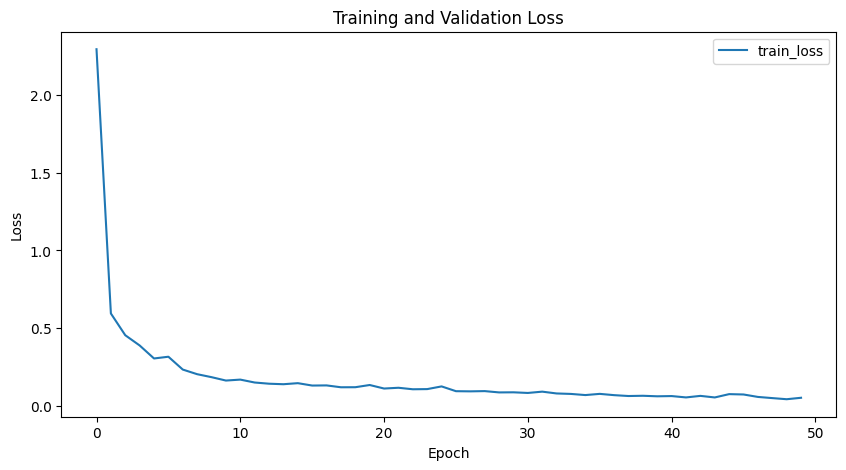

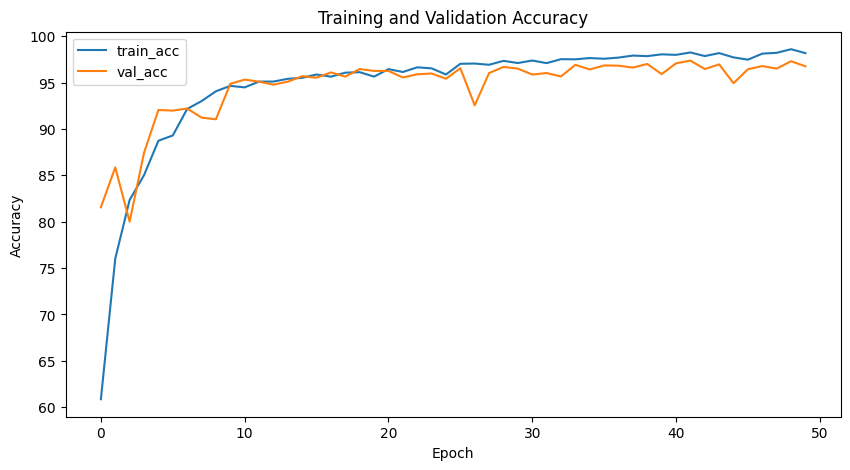

In [13]:

def plot_loss_and_acc(train_loss_list, train_acc_list, val_acc_list):
    # 绘制训练和验证损失
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_list, label='train_loss')
    #plt.plot(val_loss_list, label='val_loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # 绘制训练和验证准确率
    plt.figure(figsize=(10, 5))
    plt.plot(train_acc_list, label='train_acc')
    plt.plot(val_acc_list, label='val_acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


plot_loss_and_acc(train_loss_list, train_acc_list, val_acc_list)
from sklearn.metrics import classification_report

开始绘制混淆矩阵


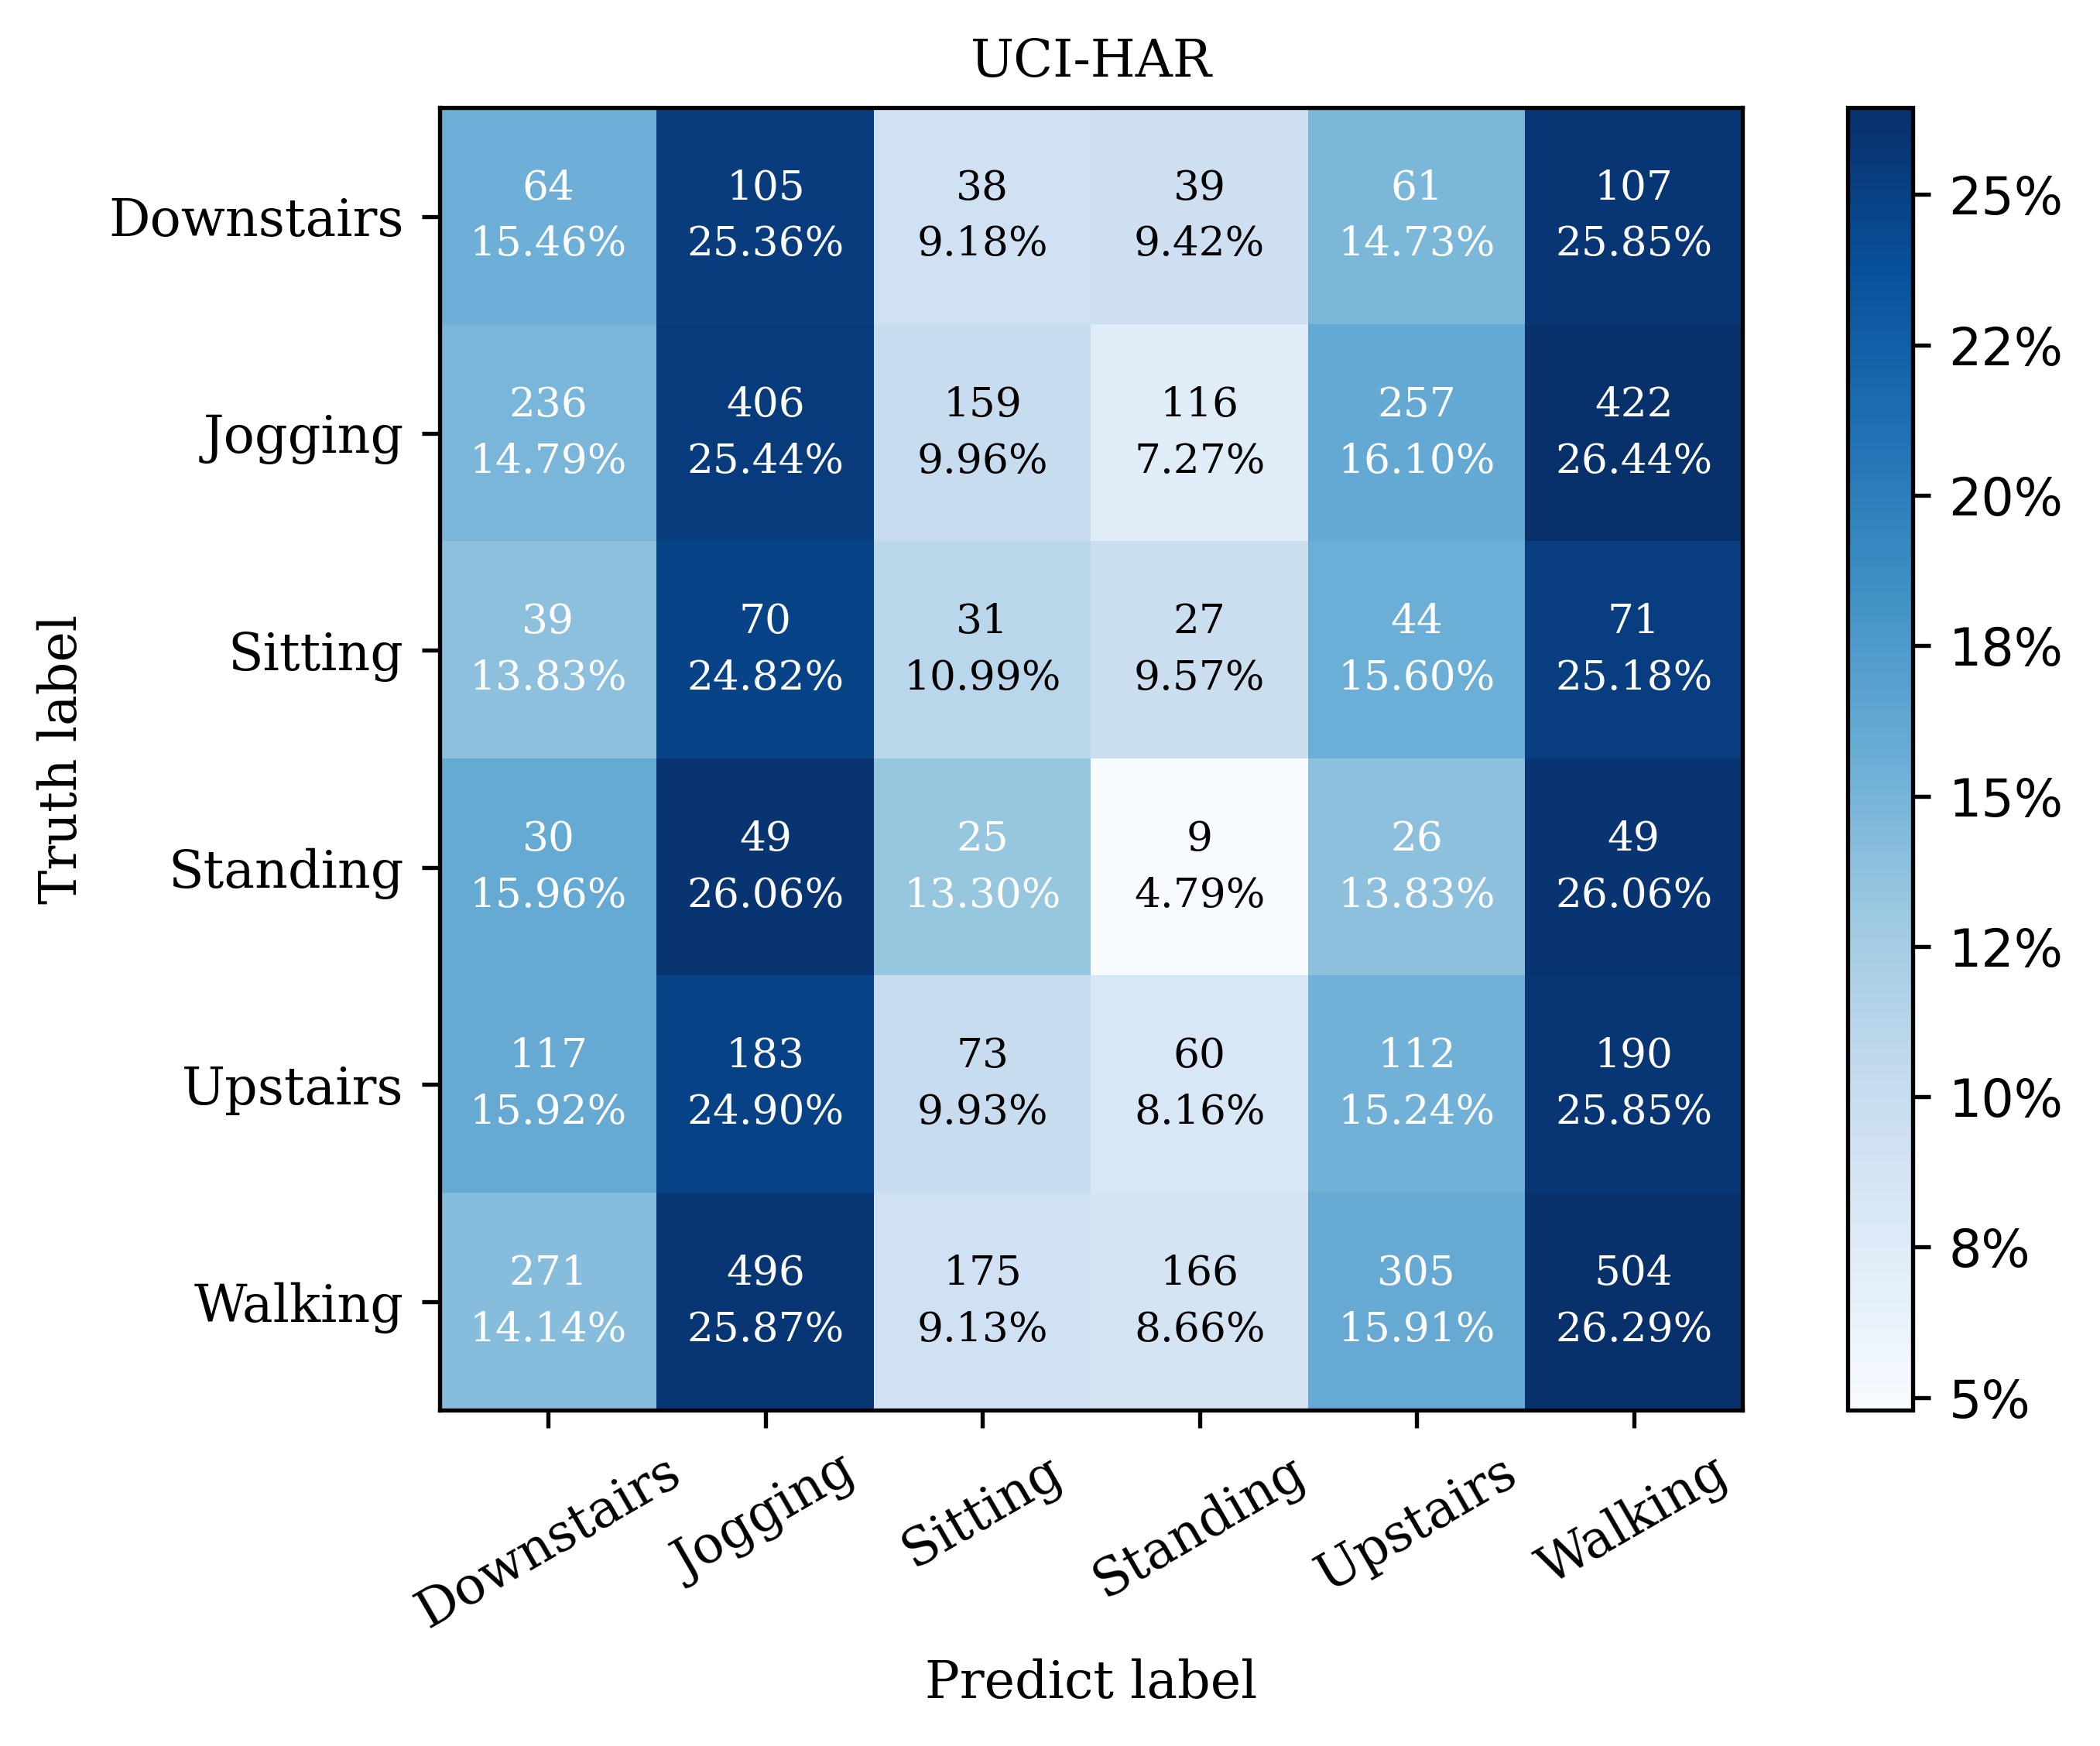

[[0.1546 0.2536 0.0918 0.0942 0.1473 0.2585]
 [0.1479 0.2544 0.0996 0.0727 0.161  0.2644]
 [0.1383 0.2482 0.1099 0.0957 0.156  0.2518]
 [0.1596 0.2606 0.133  0.0479 0.1383 0.2606]
 [0.1592 0.249  0.0993 0.0816 0.1524 0.2585]
 [0.1414 0.2587 0.0913 0.0866 0.1591 0.2629]]


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import PercentFormatter

class DrawConfusionMatrix:
    def __init__(self, labels_name, normalize=True):
        self.normalize = normalize
        self.labels_name = labels_name
        self.num_classes = len(labels_name)
        self.matrix = np.zeros((self.num_classes, self.num_classes), dtype="float32")
        self.class_counts_matrix = np.zeros((self.num_classes, self.num_classes), dtype="int32")

    def update(self, labels, predicts):
        for predict, label in zip(labels, predicts):
            self.matrix[label, predict] += 1
            self.class_counts_matrix[label, predict] += 1

    def getMatrix(self, normalize=True):
        if normalize:
            per_sum = self.matrix.sum(axis=1)  # 计算每行的和，用于百分比计算
            for i in range(self.num_classes):
                self.matrix[i] = (self.matrix[i] / per_sum[i])  # 百分比转换
            self.matrix = np.around(self.matrix, 4)  # 保留4位小数点
            self.matrix[np.isnan(self.matrix)] = 0.0  # 可能存在NaN，将其设为0
        return self.matrix

    def drawMatrix(self):
        self.matrix = self.getMatrix(self.normalize)
        font = FontProperties(family='serif', style='normal', weight='normal', size=10)
        plt.figure(dpi=480)
        plt.imshow(self.matrix, cmap=plt.cm.Blues)  # 仅画出颜色格子，没有值
        plt.title("UCI-HAR", fontproperties=font)  # 标题
        plt.xlabel("Predict label", fontproperties=font)
        plt.ylabel("Truth label", fontproperties=font)

        plt.yticks(range(self.num_classes), self.labels_name, fontproperties=font)  # y轴标签
        plt.xticks(range(self.num_classes), self.labels_name, rotation=30, fontproperties=font)  # x轴标签
        thresh = self.matrix.max() / 2.

        for x in range(self.num_classes):
            for y in range(self.num_classes):
                count = self.class_counts_matrix[y, x]
                value = str(format('%.2f' % float(self.matrix[y, x] * 100.00))) + '%'  # 数值处理
                #text = f"{count}\n{value}"
                text = count
                plt.text(x, y-0.13, text, verticalalignment='center',
                         horizontalalignment='center',
                         color="white" if self.matrix[y, x] > thresh else "black", fontproperties=font, fontsize=8)  # 写值
                plt.text(x, y+0.13, value, verticalalignment='center',
                         horizontalalignment='center',
                         color="white" if self.matrix[y, x] > thresh else "black", fontproperties=font, fontsize=8)  # 写值

        plt.tight_layout()  # 自动调整子图参数，使之填充整个图像区域

        #色条
        plt.colorbar(format=PercentFormatter(xmax=1, decimals=0, symbol='%', is_latex=False))
        plt.savefig('./ConfusionMatrix.png', bbox_inches='tight')  # bbox_inches='tight'可确保标签信息显示全
        plt.show()


def printMatrix(test_loader, model):
    labels_name = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
#     labels_name=["Walking", "Upstairs", "Downstairs", "Sitting", "Standing", "Laying"]

    drawconfusionmatrix = DrawConfusionMatrix(labels_name=labels_name)  # 实例化
    for index, (imgs, labels) in enumerate(test_loader, 1):
        labels_pd = model(imgs.float())
        predict_np = np.argmax(labels_pd.cpu().detach().numpy(), axis=-1)  # array([0,5,1,6,3,...],dtype=int64)
        labels_np = labels.numpy()  # array([0,5,0,6,2,...],dtype=int64)
        drawconfusionmatrix.update(labels_np, predict_np)  # 将新批次的predict和label更新（保存）

    drawconfusionmatrix.drawMatrix()  # 根据所有predict和label，画出混淆矩阵

    confusion_mat = drawconfusionmatrix.getMatrix()  # 你也可以使用该函数获取混淆矩阵(ndarray)
    print(confusion_mat)

print("开始绘制混淆矩阵")
printMatrix(ts_loader, model)